In [3]:
import os
from google.colab import drive

# --- Step 1: Mount your Google Drive ---
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Drive mounted successfully.")

# --- Step 2: Define the folder to search ---
# IMPORTANT: Change this to the main folder where all your trace files are.
SEARCH_DIRECTORY = "/content/drive/MyDrive/mbedtls_synthetic_traces"

# --- Step 3: Find all .h5 files in that folder ---
print(f"\nScanning for .h5 files in: {SEARCH_DIRECTORY}")
h5_file_paths = []
for root, dirs, files in os.walk(SEARCH_DIRECTORY):
    for file in files:
        if file.endswith(".h5"):
            full_path = os.path.join(root, file)
            h5_file_paths.append(full_path)

# --- Step 4: Print the list for your inspector notebook ---
print(f"\nFound {len(h5_file_paths)} .h5 files. Here is the list to copy:")
print("-" * 50)

# This prints the list in a format you can copy directly into your
# data_inspector.ipynb notebook's H5_FILES_TO_CHECK list.
print("H5_FILES_TO_CHECK = [")
for path in h5_file_paths:
    print(f"    '{path}',")
print("]")
print("-" * 50)

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted successfully.

Scanning for .h5 files in: /content/drive/MyDrive/mbedtls_synthetic_traces

Found 462 .h5 files. Here is the list to copy:
--------------------------------------------------
H5_FILES_TO_CHECK = [
    '/content/drive/MyDrive/mbedtls_synthetic_traces/attack_mbedtls_masked_20250727_190536.h5',
    '/content/drive/MyDrive/mbedtls_synthetic_traces/profiling_mbedtls_masked_20250727_190536.h5',
    '/content/drive/MyDrive/mbedtls_synthetic_traces/attack_mbedtls_masked_20250727_235810.h5',
    '/content/drive/MyDrive/mbedtls_synthetic_traces/profiling_mbedtls_masked_20250727_235810.h5',
    '/content/drive/MyDrive/mbedtls_synthetic_traces/raw_profiling_mbedtls_masked_20250728_012224.h5',
    '/content/drive/MyDrive/mbedtls_synthetic_traces/raw_attack_mbedtls_masked_20250728_012224.h5',
    '/content/drive/MyDrive/

In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


def compute_snr_chunked(traces_h5, labels_h5, byte_index, chunk_size=5000, num_classes=256, epsilon=1e-9):
    """
    Computes SNR in chunks to avoid loading the entire dataset into memory.

    Args:
        traces_h5: The HDF5 dataset object for traces.
        labels_h5: The HDF5 dataset object for labels.
        byte_index: The key byte (0-15) to analyze.
        chunk_size: How many traces to process at a time.
    """
    num_traces, trace_length = traces_h5.shape

    # Initialize arrays to accumulate statistics
    mean = np.zeros((num_classes, trace_length))
    var = np.zeros((num_classes, trace_length))
    cpt = np.zeros(num_classes, dtype=int)

    # Process the data in chunks
    for i in range(0, num_traces, chunk_size):
        # Slice a chunk from the HDF5 file (this is memory-efficient)
        traces_chunk = traces_h5[i:i+chunk_size]
        # Get the labels for the target byte
        labels_chunk = labels_h5[i:i+chunk_size, byte_index]

        # Accumulate statistics for this chunk
        for c in range(num_classes):
            # Find all traces in the chunk that correspond to class 'c'
            class_traces = traces_chunk[labels_chunk == c]
            if class_traces.shape[0] > 0:
                mean[c] += np.sum(class_traces, axis=0)
                var[c] += np.sum(class_traces**2, axis=0)
                cpt[c] += class_traces.shape[0]

    # Calculate the final mean and variance
    for c in range(num_classes):
        if cpt[c] > 0:
            mean[c] /= cpt[c]
            var[c] = (var[c] / cpt[c]) - (mean[c]**2)

    # Avoid division by zero
    var[np.abs(var) < epsilon] = epsilon

    # Calculate the final SNR
    var_of_means = np.var(mean, axis=0)
    mean_of_vars = np.mean(var, axis=0)

    return var_of_means / mean_of_vars

H5_FILES_TO_CHECK = [
    '/content/drive/MyDrive/mbedtls_synthetic_traces/attack_mbedtls_masked_20250727_190536.h5',
    '/content/drive/MyDrive/mbedtls_synthetic_traces/profiling_mbedtls_masked_20250727_190536.h5',
    '/content/drive/MyDrive/mbedtls_synthetic_traces/attack_mbedtls_masked_20250727_235810.h5',
    '/content/drive/MyDrive/mbedtls_synthetic_traces/profiling_mbedtls_masked_20250727_235810.h5',
    '/content/drive/MyDrive/mbedtls_synthetic_traces/raw_profiling_mbedtls_masked_20250728_012224.h5',
    '/content/drive/MyDrive/mbedtls_synthetic_traces/raw_attack_mbedtls_masked_20250728_012224.h5',
    '/content/drive/MyDrive/mbedtls_synthetic_traces/profiling_mbedtls_masked_20250816_221308.h5',
    '/content/drive/MyDrive/mbedtls_synthetic_traces/attack_mbedtls_masked_20250816_221308.h5',
    '/content/drive/MyDrive/mbedtls_synthetic_traces/v2_profiling_mbedtls_masked_20250820_111004.h5',
    '/content/drive/MyDrive/mbedtls_synthetic_traces/v2_attack_mbedtls_masked_20250820_111004.h5',
    '/content/drive/MyDrive/mbedtls_synthetic_traces/profiling_windows/profiling_mbedtls_masked_20250816_221308.h5',
]

def final_inspector(file_path):
    print(f"\n{'='*70}\nINSPECTING FILE: {file_path}\n{'='*70}")
    try:
        with h5py.File(file_path, "r") as f:
            if 'traces' not in f or 'labels' not in f:
                print("  [ERROR] 'traces' or 'labels' dataset not found."); return

            num_traces = f['traces'].shape[0]
            print(f"  [Shape]         Traces: {f['traces'].shape}")

            # --- Independent checks for each dataset ---
            is_profiling = f['key'].ndim == 2 and f['key'].shape[0] == num_traces
            is_rpa = f['plaintexts'].ndim == 2 and np.all(f['plaintexts'][:100, :13] == 0)

            if is_profiling:
                print("  [Key Type]      Variable Key (2D) -> PROFILING dataset")
            else:
                print("  [Key Type]      Fixed Key (1D) -> ATTACK dataset")

            if is_rpa:
                print("  [PTX Type]      Leading zeros found -> RPA dataset")
            else:
                print("  [PTX Type]      Appears to be -> RANDOM dataset")

            # --- Reshape labels if they are 1D (for old formats) ---
            labels_2d = f['labels'][:]
            if labels_2d.ndim == 1:
                labels_2d = labels_2d.reshape(num_traces, 16)

            snr15 = compute_snr_chunked(f['traces'], labels_2d, byte_index=15)
            peaks, _ = find_peaks(snr15, height=np.mean(snr15) + 3 * np.std(snr15))
            if len(peaks) < 5:
                print(f"  [Leakage]       {len(peaks)} significant peak(s) -> SINGLE PEAK version")
            else:
                print(f"  [Leakage]       {len(peaks)} significant peak(s) -> MULTIPLE PEAKS version")

    except Exception as e:
        print(f"  [ERROR] Could not process file: {e}")

# --- Run the final inspection on all files ---
for file in H5_FILES_TO_CHECK:
    final_inspector(file)


INSPECTING FILE: /content/drive/MyDrive/mbedtls_synthetic_traces/attack_mbedtls_masked_20250727_190536.h5
  [Shape]         Traces: (1, 7340)
  [Key Type]      Fixed Key (1D) -> ATTACK dataset
  [PTX Type]      Appears to be -> RANDOM dataset
  [Leakage]       145 significant peak(s) -> MULTIPLE PEAKS version

INSPECTING FILE: /content/drive/MyDrive/mbedtls_synthetic_traces/profiling_mbedtls_masked_20250727_190536.h5
  [Shape]         Traces: (1, 7340)
  [Key Type]      Fixed Key (1D) -> ATTACK dataset
  [PTX Type]      Appears to be -> RANDOM dataset
  [Leakage]       142 significant peak(s) -> MULTIPLE PEAKS version

INSPECTING FILE: /content/drive/MyDrive/mbedtls_synthetic_traces/attack_mbedtls_masked_20250727_235810.h5
  [Shape]         Traces: (2, 4736)
  [Key Type]      Fixed Key (1D) -> ATTACK dataset
  [PTX Type]      Appears to be -> RANDOM dataset
  [Leakage]       50 significant peak(s) -> MULTIPLE PEAKS version

INSPECTING FILE: /content/drive/MyDrive/mbedtls_synthetic_tra


INSPECTING FILE: /content/drive/MyDrive/mbedtls_synthetic_traces/attack_mbedtls_masked_20250727_190536.h5
  [Shape]         Traces: (1, 7340)
  [Key Type]      Fixed Key (1D) -> ATTACK dataset
  [PTX Type]      Appears to be -> RANDOM dataset
  [Leakage]       145 peak(s) -> MULTIPLE PEAKS version


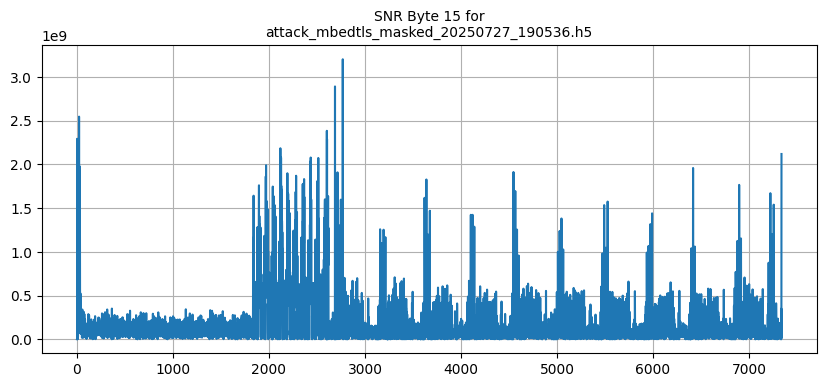


INSPECTING FILE: /content/drive/MyDrive/mbedtls_synthetic_traces/profiling_mbedtls_masked_20250727_190536.h5
  [Shape]         Traces: (1, 7340)
  [Key Type]      Fixed Key (1D) -> ATTACK dataset
  [PTX Type]      Appears to be -> RANDOM dataset
  [Leakage]       142 peak(s) -> MULTIPLE PEAKS version


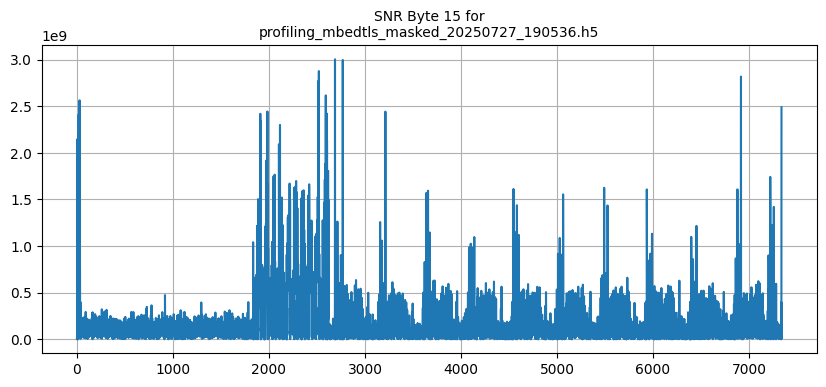


INSPECTING FILE: /content/drive/MyDrive/mbedtls_synthetic_traces/attack_mbedtls_masked_20250727_235810.h5
  [Shape]         Traces: (2, 4736)
  [Key Type]      Fixed Key (1D) -> ATTACK dataset
  [PTX Type]      Appears to be -> RANDOM dataset
  [Leakage]       50 peak(s) -> MULTIPLE PEAKS version


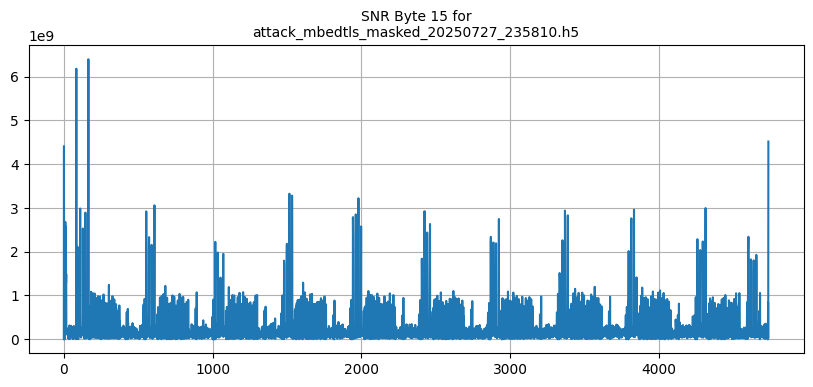


INSPECTING FILE: /content/drive/MyDrive/mbedtls_synthetic_traces/profiling_mbedtls_masked_20250727_235810.h5
  [Shape]         Traces: (2, 4736)
  [Key Type]      Fixed Key (1D) -> ATTACK dataset
  [PTX Type]      Appears to be -> RANDOM dataset
  [Leakage]       49 peak(s) -> MULTIPLE PEAKS version


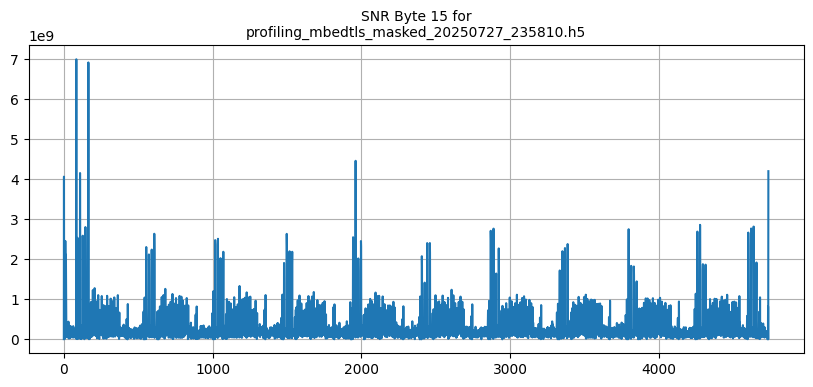


INSPECTING FILE: /content/drive/MyDrive/mbedtls_synthetic_traces/raw_profiling_mbedtls_masked_20250728_012224.h5
  [Shape]         Traces: (50001, 4736)
  [Key Type]      Fixed Key (1D) -> ATTACK dataset
  [PTX Type]      Appears to be -> RANDOM dataset
  [Leakage]       1 peak(s) -> SINGLE PEAK version


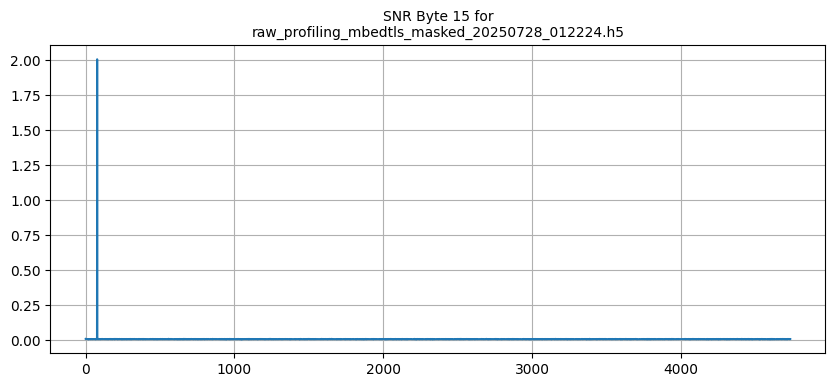


INSPECTING FILE: /content/drive/MyDrive/mbedtls_synthetic_traces/raw_attack_mbedtls_masked_20250728_012224.h5
  [Shape]         Traces: (10001, 4736)
  [Key Type]      Fixed Key (1D) -> ATTACK dataset
  [PTX Type]      Appears to be -> RANDOM dataset
  [Leakage]       1 peak(s) -> SINGLE PEAK version


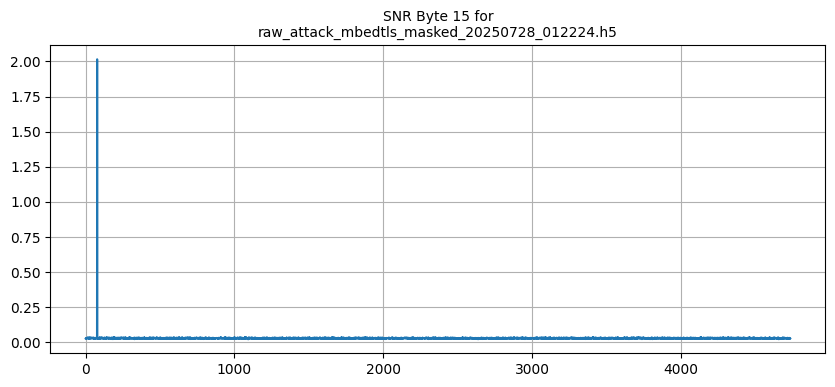


INSPECTING FILE: /content/drive/MyDrive/mbedtls_synthetic_traces/profiling_mbedtls_masked_20250816_221308.h5
  [Shape]         Traces: (3001, 4736)
  [Key Type]      Fixed Key (1D) -> ATTACK dataset
  [PTX Type]      Leading zeros found -> RPA dataset
  [Leakage]       4 peak(s) -> SINGLE PEAK version


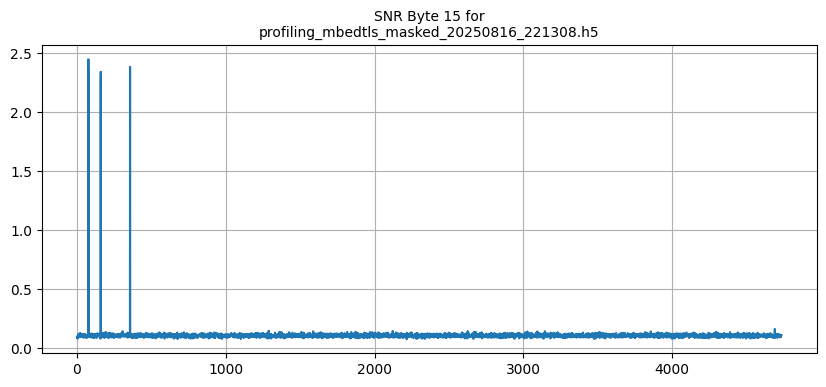


INSPECTING FILE: /content/drive/MyDrive/mbedtls_synthetic_traces/attack_mbedtls_masked_20250816_221308.h5
  [Shape]         Traces: (601, 4736)
  [Key Type]      Fixed Key (1D) -> ATTACK dataset
  [PTX Type]      Leading zeros found -> RPA dataset
  [Leakage]       163 peak(s) -> MULTIPLE PEAKS version


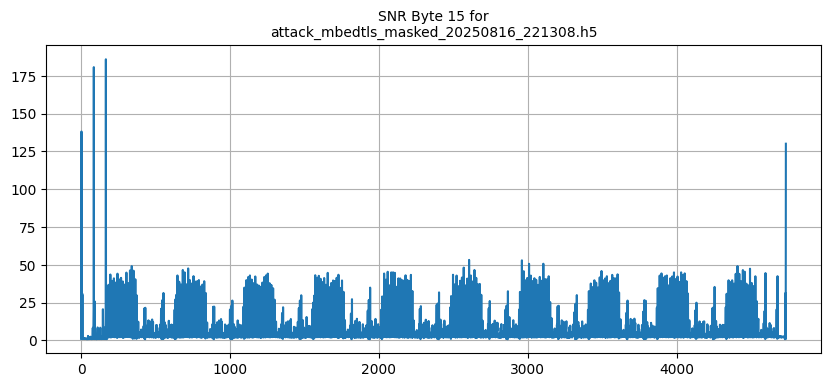


INSPECTING FILE: /content/drive/MyDrive/mbedtls_synthetic_traces/v2_profiling_mbedtls_masked_20250820_111004.h5
  [Shape]         Traces: (6001, 4732)
  [Key Type]      Variable Key (2D) -> PROFILING dataset
  [PTX Type]      Leading zeros found -> RPA dataset
  [Leakage]       2 peak(s) -> SINGLE PEAK version


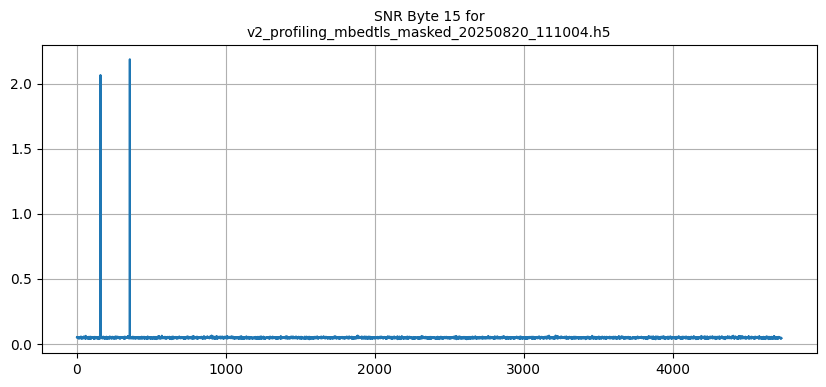


INSPECTING FILE: /content/drive/MyDrive/mbedtls_synthetic_traces/v2_attack_mbedtls_masked_20250820_111004.h5
  [Shape]         Traces: (3001, 4732)
  [Key Type]      Fixed Key (1D) -> ATTACK dataset
  [PTX Type]      Leading zeros found -> RPA dataset
  [Leakage]       40 peak(s) -> MULTIPLE PEAKS version


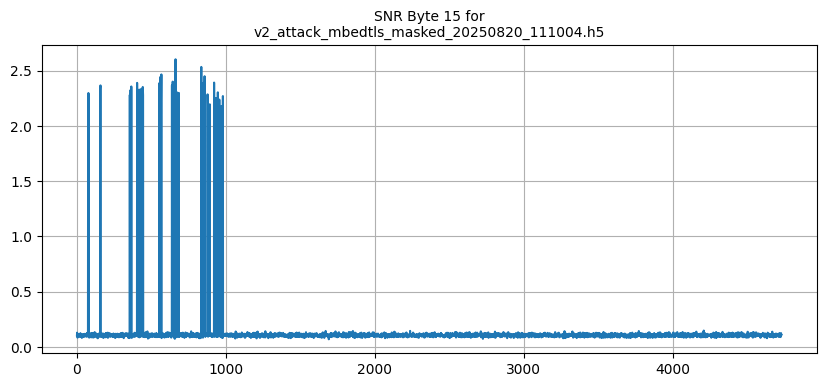


INSPECTING FILE: /content/drive/MyDrive/mbedtls_synthetic_traces/profiling_windows/profiling_mbedtls_masked_20250816_221308.h5
  [Shape]         Traces: (3001, 4736)
  [Key Type]      Fixed Key (1D) -> ATTACK dataset
  [PTX Type]      Leading zeros found -> RPA dataset
  [Leakage]       4 peak(s) -> SINGLE PEAK version


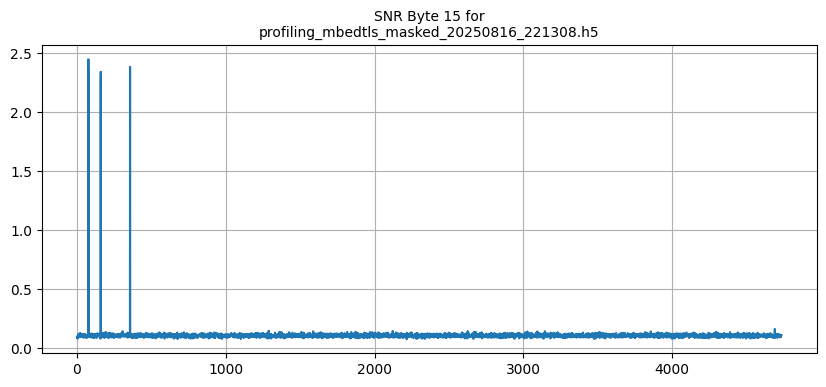

In [10]:
def final_inspector_with_plotting(file_path):
    print(f"\n{'='*70}\nINSPECTING FILE: {file_path}\n{'='*70}")
    try:
        with h5py.File(file_path, "r") as f:
            # ... (the rest of the inspector logic from the previous message) ...
            if 'traces' not in f or 'labels' not in f:
                print("  [ERROR] 'traces' or 'labels' dataset not found."); return

            num_traces = f['traces'].shape[0]
            print(f"  [Shape]         Traces: {f['traces'].shape}")

            is_profiling = f['key'].ndim == 2 and f['key'].shape[0] == num_traces
            is_rpa = f['plaintexts'].ndim == 2 and np.all(f['plaintexts'][:100, :13] == 0)

            if is_profiling: print("  [Key Type]      Variable Key (2D) -> PROFILING dataset")
            else: print("  [Key Type]      Fixed Key (1D) -> ATTACK dataset")

            if is_rpa: print("  [PTX Type]      Leading zeros found -> RPA dataset")
            else: print("  [PTX Type]      Appears to be -> RANDOM dataset")

            labels_2d = f['labels'][:]
            if labels_2d.ndim == 1: labels_2d = labels_2d.reshape(num_traces, 16)

            snr15 = compute_snr_chunked(f['traces'], labels_2d, byte_index=15)
            peaks, _ = find_peaks(snr15, height=np.mean(snr15) + 3 * np.std(snr15))

            if len(peaks) < 5: print(f"  [Leakage]       {len(peaks)} peak(s) -> SINGLE PEAK version")
            else: print(f"  [Leakage]       {len(peaks)} peak(s) -> MULTIPLE PEAKS version")

            # --- ADDED PLOTTING ---
            plt.figure(figsize=(10, 4))
            plt.title(f"SNR Byte 15 for\n{os.path.basename(file_path)}", fontsize=10)
            plt.plot(snr15)
            plt.grid(True)
            plt.show()

    except Exception as e:
        print(f"  [ERROR] Could not process file: {e}")

# --- Run the inspection ---
for file in H5_FILES_TO_CHECK:
    final_inspector_with_plotting(file)